In [1]:

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


**Data Cleaning**

In [2]:
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
for col in ['HomePlanet','Destination']:
    print(df[col].value_counts(normalize=True))

df_dist=df.copy()
df_dist['CabinDeck'] = df['Cabin'].str.split('/',expand=True)[0]
df_dist['CabinDeck'].value_counts(normalize=True)

HomePlanet
Earth     0.541922
Europa    0.250942
Mars      0.207136
Name: proportion, dtype: float64
Destination
TRAPPIST-1e      0.694983
55 Cancri e      0.211491
PSO J318.5-22    0.093526
Name: proportion, dtype: float64


CabinDeck
F    0.328938
G    0.301271
E    0.103132
B    0.091712
C    0.087944
D    0.056275
A    0.030139
T    0.000589
Name: proportion, dtype: float64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Removing outliers

<Axes: >

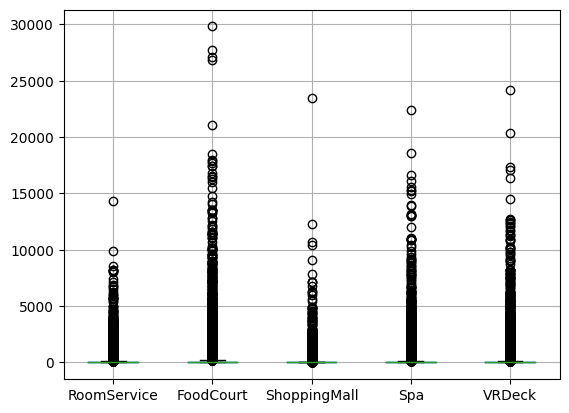

In [6]:
df.drop(['Age','Transported'],axis=1).boxplot()

In [7]:
def count_outliers(df,columns):
    iqr = df[columns].quantile(0.75)-df[columns].quantile(0.25)
    upper_bound = df[columns].quantile(0.75)+(1.5*iqr)
    return (df[columns] > upper_bound).sum()

In [8]:
spending = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
count_outliers(df,spending)

RoomService     1861
FoodCourt       1823
ShoppingMall    1829
Spa             1788
VRDeck          1809
dtype: int64

In [9]:
def clean_cols(d):
    df = d.copy()
    df['CabinDeck'] = df['Cabin'].str.split('/',expand=True)[0]
    df = df.drop(['PassengerId','Cabin','Name'],axis=1)
    df[['VIP','CryoSleep']] = df[['VIP','CryoSleep']].fillna(False)
    df[['CryoSleep','VIP']] = df[['CryoSleep', 'VIP']].astype(bool)
    df = df.dropna(how='any', subset=['HomePlanet','CabinDeck','Destination'])
    return df

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score

inital_transformer = Pipeline(steps=[('clean', FunctionTransformer(clean_cols))])

numerical_transformer_robust = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('scaler', RobustScaler())
])

numerical_transformer_standard = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('scaler', StandardScaler())
])


age_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encode',OneHotEncoder(handle_unknown='error'))
])

In [11]:
from sklearn.model_selection import train_test_split

df_clean = clean_cols(df)

X_train, X_val, y_train, y_val = train_test_split(df_clean.drop('Transported',axis=1), df_clean['Transported'], test_size=0.25)

In [12]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck']

numerical_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

preprocessor1 = ColumnTransformer([
    ('num', numerical_transformer_standard, numerical_cols),
    ('age', age_transformer, ['Age']),
    ('cat', categorical_transformer, categorical_cols)
])

preprocessor2 = ColumnTransformer([
    ('num', numerical_transformer_robust, numerical_cols),
    ('age', age_transformer, ['Age']),
    ('cat', categorical_transformer, categorical_cols)
])


In [13]:
def eval_model(pipe, name, X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val):
    pipe.fit(X_train,y_train)
    val_pred = pipe.predict(X_val)
    
    train_acc = accuracy_score(y_val,val_pred)
    
    print(f'Model: {name}')
    print(f'Training Accuracy: {train_acc}')

SVM Model

In [14]:
from sklearn.svm import SVC

svc_stnd = Pipeline(steps=[
    ('preprocess', preprocessor1),
    ('model', SVC())
])

svc_robust = Pipeline(steps=[
    ('preprocess', preprocessor2),
    ('model', SVC())
])

In [15]:
eval_model(svc_stnd, 'SVC Standard Scaling')
eval_model(svc_robust, 'SVC Robust Scaling')

Model: SVC Standard Scaling
Training Accuracy: 0.7992125984251969
Model: SVC Robust Scaling
Training Accuracy: 0.7928149606299213


KNN Model

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn_stnd = Pipeline(steps=[
    ('preprocess', preprocessor1),
    ('model', KNeighborsClassifier())
])

knn_robust = Pipeline(steps=[
    ('preprocess', preprocessor2),
    ('model', KNeighborsClassifier())
])

In [17]:
eval_model(knn_stnd, 'KNN Standard Scaling')
eval_model(knn_robust, 'KNN Robust Scaling')

Model: KNN Standard Scaling
Training Accuracy: 0.7632874015748031
Model: KNN Robust Scaling
Training Accuracy: 0.7682086614173228


KNN Seemed to score better than the SVC model. Let's see if we can improve our accuracy by adjusting some hyperparameters. Let's stick to the datacleaning process using the Robust Scaler as its scoring slightly better than the Standard Scaler.

In [18]:
from sklearn.model_selection import GridSearchCV

params = {'model__n_neighbors': [2,3,4,5,8,10],'model__weights':['uniform','distance']}

op_model = GridSearchCV(knn_robust,params,scoring='accuracy')

op_model.fit(X_train,y_train)

print(op_model.best_score_)
print(op_model.best_params_)

0.7772881753193484
{'model__n_neighbors': 10, 'model__weights': 'uniform'}


While more neighbors improved test accuracy score, it tended to cause overfitting to the training data. Therefored I decided to go with 3 neighbors in my final model

In [19]:
final_model = Pipeline(steps=[
    ('preprocess', preprocessor2),
    ('model', KNeighborsClassifier(n_neighbors=3))
])

eval_model(final_model, 'Optimized KNN Model')

Model: Optimized KNN Model
Training Accuracy: 0.7573818897637795


Neural Network

In [20]:
from sklearn.neural_network import MLPClassifier

nn_stnd = Pipeline(steps=[
    ('preprocess', preprocessor1),
    ('model', MLPClassifier())
])

nn_robust = Pipeline(steps=[
    ('preprocess', preprocessor2),
    ('model', MLPClassifier())
])

In [21]:
eval_model(nn_stnd, 'Neural Network Standard Scaling')
eval_model(nn_robust, 'Neural Network Scaling')

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: Neural Network Standard Scaling
Training Accuracy: 0.8011811023622047
Model: Neural Network Scaling
Training Accuracy: 0.8080708661417323


Decision Tree Classifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_stnd = Pipeline(steps=[
    ('preprocess', preprocessor1),
    ('model', DecisionTreeClassifier())
])

dt_robust = Pipeline(steps=[
    ('preprocess', preprocessor2),
    ('model', DecisionTreeClassifier())
])

eval_model(dt_stnd, 'Decision Tree Standard Scaling')
eval_model(dt_robust, 'Decision Tree Robust Scaling')

Model: Decision Tree Standard Scaling
Training Accuracy: 0.7239173228346457
Model: Decision Tree Robust Scaling
Training Accuracy: 0.7273622047244095


**_______________________________________________________________________________________________________________________________________**

Improving on the Decision Tree Model:

In [23]:
def clean_cols(d):
    df = d.copy()
    df['CabinDeck'] = df['Cabin'].str.split('/',expand=True)[0]
    df = df.drop(['PassengerId','Cabin','Name'],axis=1)
    df[['VIP','CryoSleep']] = df[['VIP','CryoSleep']].fillna(False)
    df[['CryoSleep','VIP']] = df[['CryoSleep', 'VIP']].astype(bool)
    df = df.dropna(how='any', subset=['HomePlanet','CabinDeck','Destination'])
    df[['RoomService','ShoppingMall','Spa','VRDeck','FoodCourt']] = df[['RoomService','ShoppingMall','Spa','VRDeck','FoodCourt']].fillna(0)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df = pd.get_dummies(df, columns=['HomePlanet','CryoSleep','VIP','CabinDeck','Destination'])
    return df

In [24]:
df_tree = clean_cols(df)
df_tree.isnull().sum()

Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Transported                  0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
VIP_False                    0
VIP_True                     0
CabinDeck_A                  0
CabinDeck_B                  0
CabinDeck_C                  0
CabinDeck_D                  0
CabinDeck_E                  0
CabinDeck_F                  0
CabinDeck_G                  0
CabinDeck_T                  0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
dtype: int64

In [25]:
X_train, X_val, y_train, y_val = train_test_split(df_tree.drop('Transported',axis=1), df_tree['Transported'],test_size=0.2)

In [26]:
params = {
    'criterion' : ['gini','entropy'],
    'max_depth' : [3,5,7,10],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1, 2, 5]
}

grid = GridSearchCV(DecisionTreeClassifier(),params,scoring='accuracy', cv=5)

grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.7756923076923077
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


**Submission**

In [27]:
def clean_cols_mod(d):
    df = d.copy()
    df['CabinDeck'] = df['Cabin'].str.split('/',expand=True)[0]
    df = df.drop(['Cabin','Name'],axis=1)
    df[['VIP','CryoSleep']] = df[['VIP','CryoSleep']].fillna(False)
    df[['CryoSleep','VIP']] = df[['CryoSleep', 'VIP']].astype(bool)
    for col in ['HomePlanet','CabinDeck','Destination']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df[['RoomService','ShoppingMall','Spa','VRDeck','FoodCourt']] = df[['RoomService','ShoppingMall','Spa','VRDeck','FoodCourt']].fillna(0)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df = pd.get_dummies(df, columns=['HomePlanet','CryoSleep','VIP','CabinDeck','Destination'])
    return df

In [28]:
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_test = clean_cols_mod(test_data)

X_test = df_test.drop('PassengerId',axis=1)

test_preds = grid.best_estimator_.predict(X_test)

tree_submission = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Transported': test_preds})

In [29]:
tree_submission.to_csv('submission1.csv',index=False)